# Timeseries of obs in East Africa
Note: this requires raw precipitation time series for all observed data products, which can be downloaded from each products' respective data storage.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats
import shapely
import os
import re
import glob
import warnings
import matplotlib as mpl
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from funcs_support import get_filepaths,get_params,utility_print,subset_to_srat,area_mean
from funcs_support2 import seasmeans
from funcs_load import load_raws
dir_list = get_params()

extra_fonts = {'lato':mpl.font_manager.FontProperties(fname=dir_list['aux']+'fonts/Lato-Regular.ttf'),
 'lato-bold':mpl.font_manager.FontProperties(fname=dir_list['aux']+'fonts/Lato-Bold.ttf')}

In [2]:
subset_params = {'time':slice('1900-01-01','2024-12-31'),'lat':slice(-3,12.5),'lon':slice(32,55)}

In [4]:
# Load 
dss = load_raws({'varname':'pr','freq':'Amon','run':'obs'},
               subset_params = subset_params,force_load = True)

# Get mean over double-peaked area
dss = {mod:area_mean(subset_to_srat(ds['pr'].isel(run=0))) for mod,ds in dss.items()}

# Homogenize time format
for mod in dss:
    dss[mod]['time'] = pd.date_range(str(dss[mod]['time'].min().values)[0:8]+'01',
                                     str(dss[mod]['time'].max().values)[0:8]+'30',
                                     freq = '1MS')+pd.DateOffset(days=15)

# Concatenate into single ds
dss = xr.concat([ds for mod,ds in dss.items()],
                dim=pd.Index([mod for mod in dss],name='model'))
dss = dss.to_dataset(name='pr')

# Get seasonal means
dssm = seasmeans(dss,{'MAM':[3,5],'OND':[10,12]})

# Calculate anomalies
dssm['pranom'] = dssm['pr']/dssm['pr'].sel(year=slice(1990,1999)).mean('year')

/home/kschwarz/projects/future_stability/figures/figureS1.pdf saved!
/home/kschwarz/projects/future_stability/figures/figureS1.png saved!


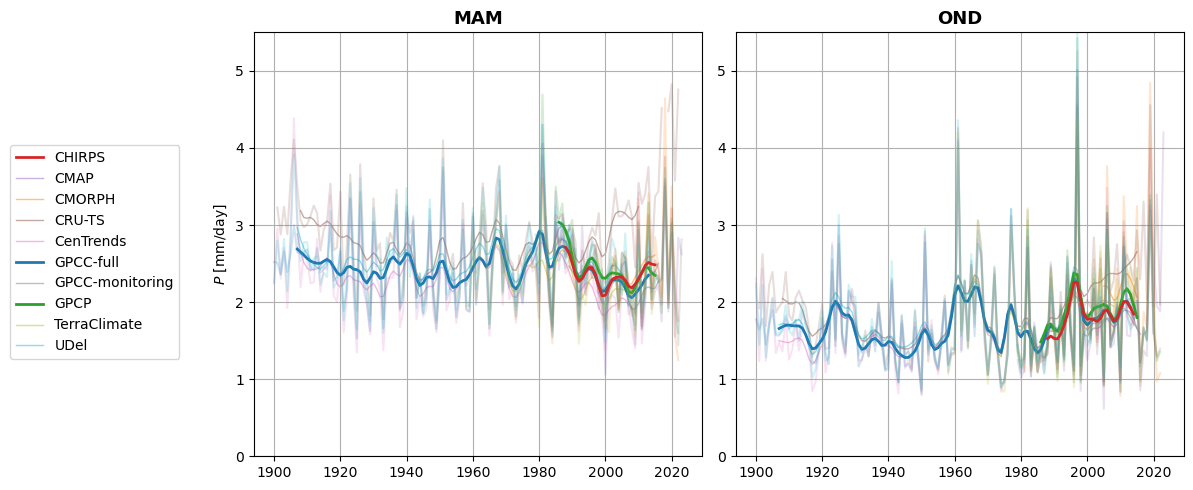

In [8]:
save_fig = True
output_fn = dir_list['figs']+'figureS1'

fig = plt.figure(figsize=(12,5))

colors = {'CHIRPS':'tab:red', 'CMAP':'tab:purple', 'CMORPH':'tab:orange', 'CRU-TS':'tab:brown', 
          'CenTrends':'tab:pink',
       'GPCC-full':'tab:blue', 'GPCC-monitoring':'tab:gray', 'GPCP':'tab:green', 
          'TerraClimate':'tab:olive', 'UDel':'tab:cyan'}


roll_w = 15
# Get gaussian weight vector for rolling avg
weight = xr.DataArray(stats.norm(0, 1).pdf(np.arange(-5,5,10/roll_w)), dims=['window'])
# Don't forget to normalize by the weight sum!!!!!!!
weight = weight/weight.sum()

for seas,seas_idx in zip(dssm.season.values,range(dssm.sizes['season'])):
    ax = plt.subplot(1,2,seas_idx+1)

    for mod in colors:
        plot_data = dssm.sel(model=mod,season=seas).pr
        plot_data.plot(color=colors[mod],alpha=0.2)

        plot_data = plot_data.rolling(year=roll_w,center=True).construct('window').dot(weight)

        if mod in ['CHIRPS','GPCP','GPCC-full']:
            if mod == 'CHIRPS':
                zorder = 3
            else:
                zorder = 2
            alpha = 1
            linewidth=2
        else:
            zorder = 1
            alpha = 0.5
            linewidth=1

        plot_data.plot(color=colors[mod],label=mod,zorder=zorder,alpha=alpha,linewidth=linewidth)

    ax.set_ylim([0,5.5])

    if seas_idx == 0:
        ax.set_ylabel(r'$P$ [mm/day]')
        ax.legend(bbox_to_anchor=(-0.15,0.75))
    ax.set_title(seas,fontweight='bold',fontsize=13)
    ax.set_xlabel('')

    ax.grid()

plt.tight_layout()
if save_fig:
    utility_print(output_fn)

### Alternate version showing precip anomalies instead of levels

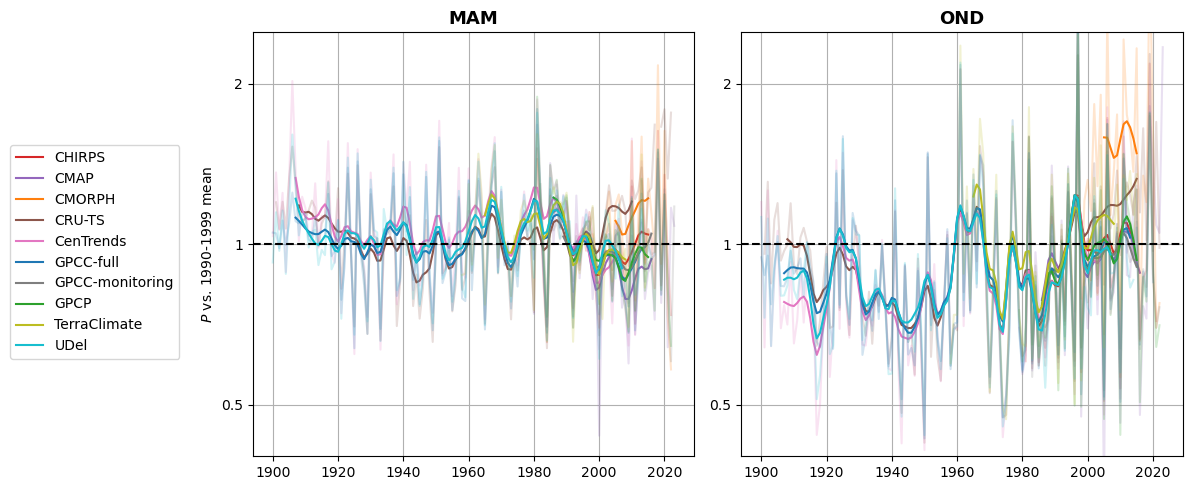

In [9]:
save_fig = False
output_fn = dir_list['figs']+'EXTRAfigureS1'

fig = plt.figure(figsize=(12,5))

colors = {'CHIRPS':'tab:red', 'CMAP':'tab:purple', 'CMORPH':'tab:orange', 'CRU-TS':'tab:brown', 
          'CenTrends':'tab:pink',
       'GPCC-full':'tab:blue', 'GPCC-monitoring':'tab:gray', 'GPCP':'tab:green', 
          'TerraClimate':'tab:olive', 'UDel':'tab:cyan'}


roll_w = 15
# Get gaussian weight vector for rolling avg
weight = xr.DataArray(stats.norm(0, 1).pdf(np.arange(-5,5,10/roll_w)), dims=['window'])
# Don't forget to normalize by the weight sum!!!!!!!
weight = weight/weight.sum()

for seas,seas_idx in zip(dssm.season.values,range(dssm.sizes['season'])):
    ax = plt.subplot(1,2,seas_idx+1)

    for mod in colors:
        plot_data = dssm.sel(model=mod,season=seas).pranom
        plot_data.plot(color=colors[mod],alpha=0.2)

        plot_data = plot_data.rolling(year=roll_w,center=True).construct('window').dot(weight)

        plot_data.plot(color=colors[mod],label=mod)


    ax.axhline(1,color='k',linestyle='--')
    ax.set_yscale('log')
    ax.set_yticks([0.5,1,2],['0.5','1','2'])
    ax.set_yticks([],minor=True)
    ax.set_ylim([1/2.5,2.5])

    if seas_idx == 0:
        ax.set_ylabel(r'$P$ vs. 1990-1999 mean')
        ax.legend(bbox_to_anchor=(-0.15,0.75))
    ax.set_title(seas,fontweight='bold',fontsize=13)
    ax.set_xlabel('')

    ax.grid()

plt.tight_layout()
if save_fig:
    utility_print(output_fn)